In [1]:
from utils.hoda_dataset_reader import read_hoda_cdb, read_hoda_dataset
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout,Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import cv2
from random import randint
from math import sqrt, ceil
import os
from PIL import Image

In [2]:
hoda_dir = "hoda-dataset/"
X_train, y_train = read_hoda_dataset(
    dataset_path=hoda_dir + "Train-60000.cdb",
    images_height=32,
    images_width=32,
    one_hot=False,
    reshape=True,
)

X_test, y_test = read_hoda_dataset(
    dataset_path=hoda_dir + "Test-20000.cdb",
    images_height=32,
    images_width=32,
    one_hot=False,
    reshape=True,
)

X_validation, y_validation = read_hoda_dataset(
    dataset_path=hoda_dir + "RemainingSamples.cdb",
    images_height=32,
    images_width=32,
    one_hot=False,
    reshape=True,
)

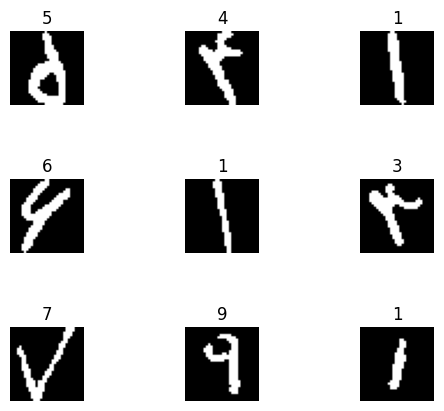

In [3]:
total = 9
row = col = ceil(sqrt(total))
fig = plt.figure()
fig.subplots_adjust(hspace=1)

for i in range(total):
    random_index = randint(0, 60000)
    fig.add_subplot(row, col, i + 1)
    plt.title(int(y_train[random_index]))
    plt.imshow(X_train[random_index].reshape([32, 32]), cmap="gray")
    plt.axis("off")

plt.show()

In [4]:
# Normalization
# our data is aleady normalized

# Reshape the data to fit the model
X_train = X_train.reshape(-1, 32, 32, 1)
X_test = X_test.reshape(-1, 32, 32, 1)
X_validation = X_validation.reshape(-1, 32, 32, 1)

In [5]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_validation = to_categorical(y_validation, num_classes=10)

In [6]:
# Create the model
model = Sequential()

# Add model layers
model.add(Input(shape=(32, 32, 1)))
model.add(Conv2D(64, kernel_size=3, activation="relu", padding="same"))
model.add(Conv2D(64, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=3, activation="relu", padding="same"))
model.add(Conv2D(128, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,358,986 (9.00 MB)

 Trainable params: 2,358,986 (9.00 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 225s 119ms/step - accuracy: 0.9376 - loss: 0.1980 - val_accuracy: 0.9901 - val_loss: 0.0336
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 225s 120ms/step - accuracy: 0.9905 - loss: 0.0329 - val_accuracy: 0.9929 - val_loss: 0.0227
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 232s 124ms/step - accuracy: 0.9937 - loss: 0.0223 - val_accuracy: 0.9932 - val_loss: 0.0265
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 234s 125ms/step - accuracy: 0.9944 - loss: 0.0195 - val_accuracy: 0.9945 - val_loss: 0.0192
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 236s 126ms/step - accuracy: 0.9964 - loss: 0.0135 - val_accuracy: 0.9949 - val_loss: 0.0197
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 234s 125ms/step - accuracy: 0.9962 - loss: 0.0121 - val_accuracy: 0.9957 - val_loss: 0.0182
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 225s 120ms/step - accuracy: 0.9969 - loss: 0.0103 - val_accuracy: 0.9926 - val_loss: 0.0356
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 224s 119ms/step - ac

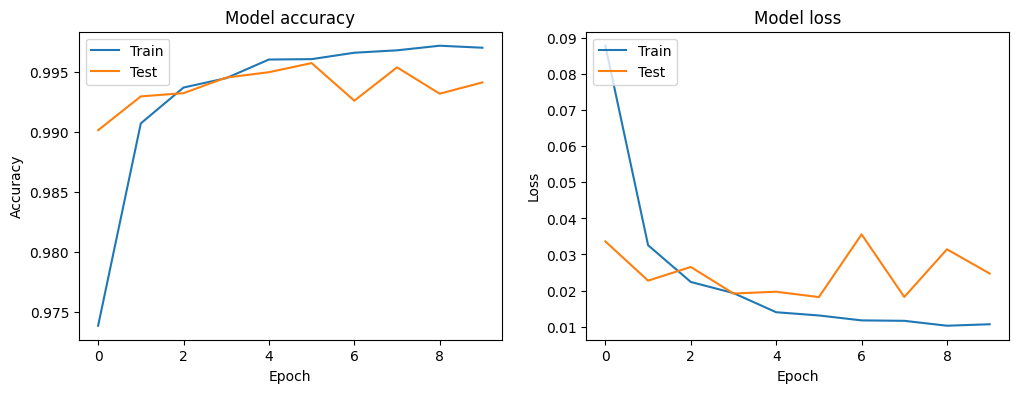

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

625/625 - 17s - 27ms/step - accuracy: 0.9923 - loss: 0.0344

Test accuracy: 0.9923499822616577

Test loss: 0.03435000032186508


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


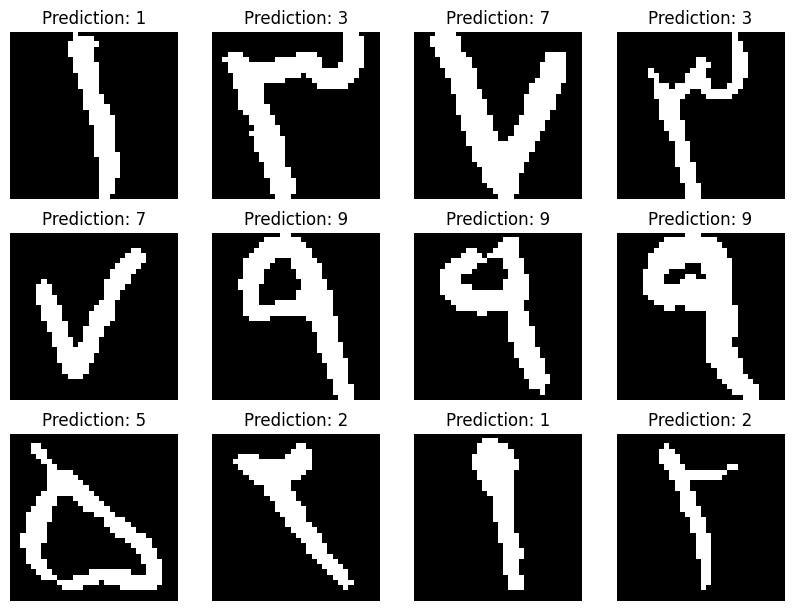

In [11]:
total = 12

# Plot the sample
plt.figure(figsize=(10, 10))
columns = 4
rows = total // columns + 1

for i in range(total):
    sample_index = np.random.randint(0, len(X_test))  # Select a random index
    sample = X_test[sample_index]  # Get the sample
    sample = sample.reshape(1, 32, 32, 1)  # Reshape the sample
    prediction = model.predict(sample).argmax()  # Predict the label
    # Plot the image
    plt.subplot(rows, columns, i + 1)
    plt.imshow(
        sample.reshape(32, 32), cmap="gray"
    )  # Adjust the reshape parameters as per your image size
    plt.title(f"Prediction: {prediction}")
    plt.axis("off")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


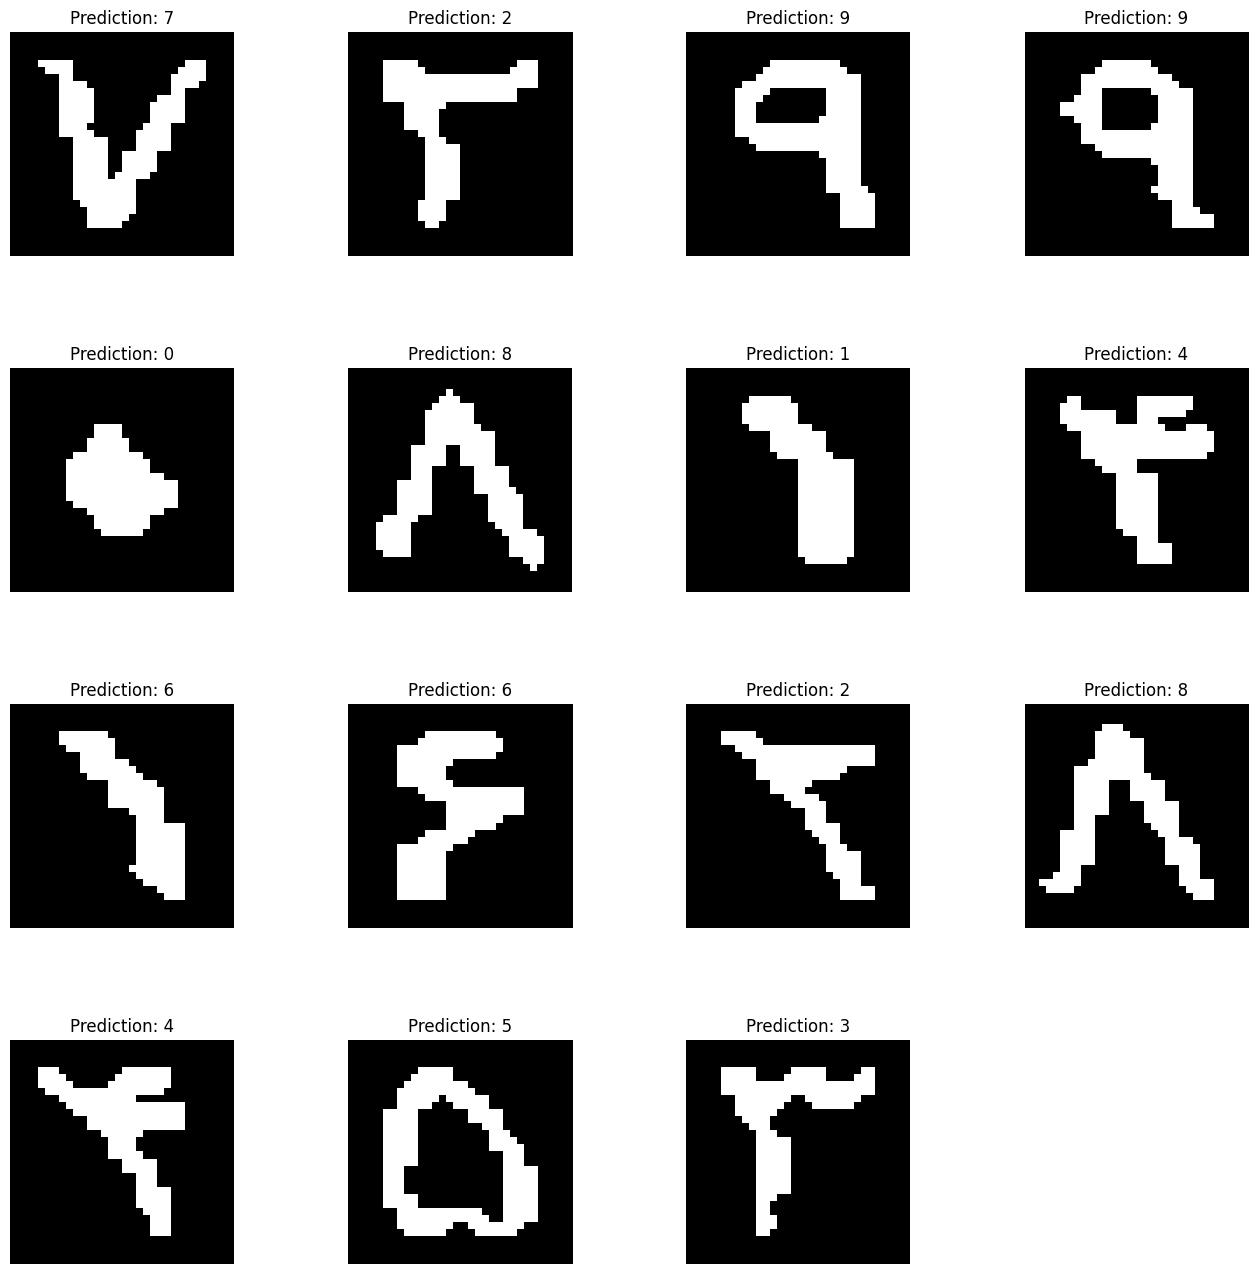

In [12]:
# Directory path
directory = "example"

# Get the list of image files in the directory
image_files = [
    file
    for file in os.listdir(directory)
    if (file.endswith(".jpg") or file.endswith(".png"))
]

# Plot the images
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

columns = 4
rows = len(image_files) // columns + 1
for i, file in enumerate(image_files):
    img = Image.open(os.path.join(directory, file))
    # Resize the image
    img = img.resize((32, 32))  # Adjust size as needed
    # Convert the image to grayscale if needed
    img = img.convert("L")
    img_array = np.array(img)  # Convert PIL image to numpy array

    # Apply thresholding to obtain binary image
    _, digit_binary = cv2.threshold(
        img_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Reshape and scale the image
    img_array = digit_binary.reshape(-1, 32, 32, 1) / 255.0
    # Make predictions using your model
    prediction = model.predict(img_array).argmax()

    # Plot the image
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(digit_binary, cmap="gray")
    plt.title(f"Prediction: {prediction}")
    plt.axis("off")

plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step


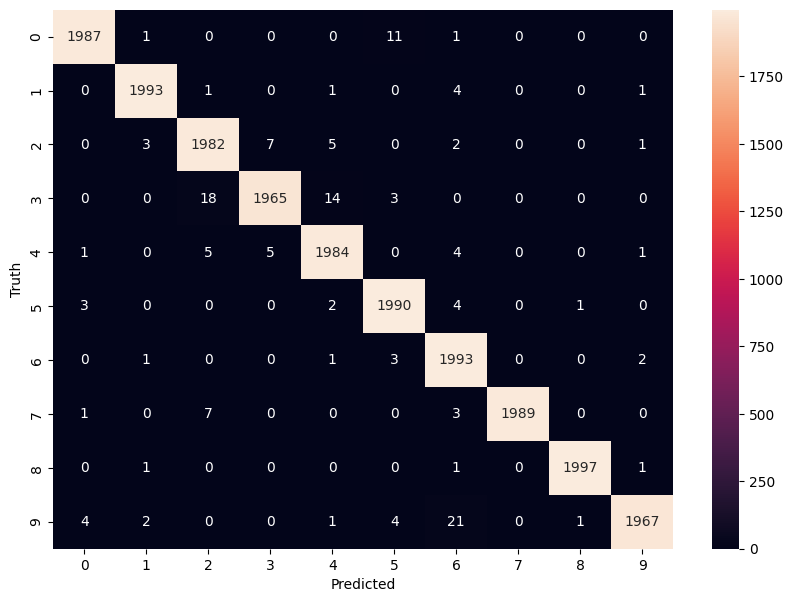

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have a trained model and a test set (X_test, y_test)

# Convert test labels from one-hot encoded to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Predict probabilities on the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities into class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [14]:
import pandas as pd
from sklearn.metrics import classification_report

# Compute classification report
report = classification_report(y_test_labels, y_pred, output_dict=True)

# Convert report to dataframe for easier visualization
report_df = pd.DataFrame(report).transpose()

print(report_df)

              precision   recall  f1-score      support
0              0.995491  0.99350  0.994494   2000.00000
1              0.996002  0.99650  0.996251   2000.00000
2              0.984600  0.99100  0.987790   2000.00000
3              0.993930  0.98250  0.988182   2000.00000
4              0.988048  0.99200  0.990020   2000.00000
5              0.989557  0.99500  0.992271   2000.00000
6              0.980325  0.99650  0.988346   2000.00000
7              1.000000  0.99450  0.997242   2000.00000
8              0.998999  0.99850  0.998750   2000.00000
9              0.996959  0.98350  0.990184   2000.00000
accuracy       0.992350  0.99235  0.992350      0.99235
macro avg      0.992391  0.99235  0.992353  20000.00000
weighted avg   0.992391  0.99235  0.992353  20000.00000


In [15]:
report_df = report_df.drop('support', axis=1)

report_df = report_df.round(3)

# Transpose DataFrame
report_df_transposed = report_df.transpose()

# Convert transposed DataFrame to Markdown
markdown_table = report_df_transposed.to_markdown()

print(markdown_table)

|           |     0 |     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9 |   accuracy |   macro avg |   weighted avg |
|:----------|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----------:|------------:|---------------:|
| precision | 0.995 | 0.996 | 0.985 | 0.994 | 0.988 | 0.99  | 0.98  | 1     | 0.999 | 0.997 |      0.992 |       0.992 |          0.992 |
| recall    | 0.994 | 0.996 | 0.991 | 0.982 | 0.992 | 0.995 | 0.996 | 0.994 | 0.998 | 0.984 |      0.992 |       0.992 |          0.992 |
| f1-score  | 0.994 | 0.996 | 0.988 | 0.988 | 0.99  | 0.992 | 0.988 | 0.997 | 0.999 | 0.99  |      0.992 |       0.992 |          0.992 |


In [16]:
# save the model

model_dir = "models"
# Check if the model directory exists, if not create it
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save("models/PDRM.keras")
# PDRM => Persian Digit Recognition Model